### Rolling window calculations - annual

Using annual data.  Calculating 3 monthly mean of indices, then find maximum and minimum values, then calculate range.

Export data as a binary for use in Peter Tan's unsupervised learning program.

In [ ]:
import builtins
import numpy as np
import xarray as xr
import os
import pandas as pd

#import custom functions
import sys
sys.path.append('src')
import DEAPlotting
from read_envi_header import read_envi_header

In [ ]:
#user inputs
start_year = 2000
end_year = 2018
directory = '/g/data1a/r78/cb3058/dea-notebooks/crop-extents/data_dir/wagga/'
index_name = 'brightness' 
# 'mndwi' 'brightness' 'msavi'

In [ ]:
#generate a list of years to help with the function below
z = range(start_year,end_year+1, 1)
years = []
for zz in z:
    years.append(str(zz))

# Get a list of the folders in the directory
def get_immediate_subdirectories(a_dir):
    return [name for name in os.listdir(a_dir)
            if os.path.isdir(os.path.join(a_dir, name))]

for folder in get_immediate_subdirectories(directory):
    for year in years:
        #progress indicator
        print("working on year: " + index_name + ", " + year)
        
        #grab the envi binary image and header files
        filename_img = directory + year + "/" + index_name + ".img"
        filename_hdr = directory + year + "/" + index_name + ".hdr"
        
        def rollingaverage_range(filename_img, filename_hdr, index_name):
            """
            Using .img and .hdr files as inputs, this function
            computes the range of a given index based upon a rolling
            3 month mean.  The result is exported to a .img file
            for use in the classification algorithm.
            
            """
            #open files
            index = xr.open_rasterio(filename_img)
            hdr = read_envi_header(filename_hdr)
            #get time info from hdr file
            time_str = hdr['band names']
            time = []
            for i in time_str:
                x = pd.to_datetime(i, format='%Y-%m-%d')
                time.append(x)
            #place data into a neat xarray object
            index = xr.DataArray(index.values, coords = [time, index.y, index.x],
                                 dims = ['time', 'y', 'x'], name=index_name, attrs=index.attrs)
            #remove no data -999 values
            index = index.where(index>-998, np.nan)
            #calculate rolling mean
            index_3M = index.resample(time='3M').mean('time', skipna=True)
            #calculate range
            index_3M_max = index_3M.max('time')
            index_3M_min = index_3M.min('time')
            index_3M_range = index_3M_max - index_3M_min
            #replace nans with -999
            index_3M_range = index_3M_range.fillna(-999.) 
            #export
            index_3M_range.values.tofile(directory + year + "/" + index_name+'_range.img')
        
        rollingaverage_range(filename_img, filename_hdr, index_name=index_name)
    break
print('finished')

### visualizing bands

The following code is an adapatation from above that returns an xarray for exploration purposes

In [ ]:
def rollingaverage_range_xr(filename_img, filename_hdr, index_name):
    index = xr.open_rasterio(filename_img)
    hdr = read_envi_header(filename_hdr)
    time_str = hdr['band names']
    time = []
    for i in time_str:
        x = pd.to_datetime(i, format='%Y-%m-%d')
        time.append(x)

    index = xr.DataArray(index.values, coords = [time, index.y, index.x],
                         dims = ['time', 'y', 'x'], name=index_name, attrs=index.attrs)

    index = index.where(index>-998, np.nan)

    index_3M = index.resample(time='3M').mean('time', skipna=True)

    index_3M_max = index_3M.max('time')
    index_3M_min = index_3M.min('time')
    index_3M_range = index_3M_max - index_3M_min
    index_3M_range = index_3M_range.fillna(-999.) 
    return index_3M_range

In [ ]:
folder = '/g/data1a/r78/cb3058/dea-notebooks/crop-extents/data_dir/griffith/2017/'
filename_img = folder + 'brightness.img'
filename_hdr = folder + 'brightness.hdr'

brightness_range = rollingaverage_range_xr(filename_img, filename_hdr, index_name='brightness')

In [ ]:
filename_img = folder + 'msavi.img'
filename_hdr = folder + 'msavi.hdr'

msavi_range = rollingaverage_range_xr(filename_img, filename_hdr, index_name='msavi')

In [ ]:
filename_img = folder + 'mndwi.img'
filename_hdr = folder + 'mndwi.hdr'

wetness_range = rollingaverage_range_xr(filename_img, filename_hdr, index_name='mndwi')

In [ ]:
ds = xr.Dataset({'wetness_range':wetness_range,'msavi_range': msavi_range,'brightness_range': brightness_range})

In [ ]:
DEAPlotting.rgb(ds, bands=['wetness_range', 'msavi_range', 'brightness_range'], size=10)

### Trialling different stats

Code for testing other statistics e.g. STD insted of range etc.

In [ ]:
def rollingaverage_max_xr(filename_img, filename_hdr, index_name):
    index = xr.open_rasterio(filename_img)
    hdr = read_envi_header(filename_hdr)
    time_str = hdr['band names']
    time = []
    for i in time_str:
        x = pd.to_datetime(i, format='%Y-%m-%d')
        time.append(x)

    index = xr.DataArray(index.values, coords = [time, index.y, index.x],
                         dims = ['time', 'y', 'x'], name=index_name, attrs=index.attrs)

    index = index.where(index>-998, np.nan)

    index_3M = index.resample(time='M').mean('time', skipna=True)
    index_3M_max = index_3M.mean('time')
    index_3M_max = index_3M_max.fillna(-999.) 
    return index_3M_max

In [ ]:
folder = '/g/data1a/r78/cb3058/dea-notebooks/crop-extents/data_dir/griffith/2017/'
filename_img = folder + 'brightness.img'
filename_hdr = folder + 'brightness.hdr'

brightness_max = rollingaverage_max_xr(filename_img, filename_hdr, index_name='brightness')

In [ ]:
brightness_max.plot()

### Cleaning classification results

Attempting to create a 'noise' testing algoritm to clean the results of the binary crop/no-crop classification

NB Currently, this isnt working 7/5/19


In [ ]:
#user inputs
start_year = 2000
end_year = 2018
directory = '/g/data/r78/cb3058/dea-notebooks/crop-extents/data_dir/griffith/'
index_name = 'urban_spec_5c' 

In [ ]:
z = range(start_year,end_year+1, 1)
years = []
for zz in z:
    years.append(str(zz))

time=[]
for year in years:
    v = pd.to_datetime(year, format='%Y')
    time.append(v)


def clean_tsApproach(directory):
    data_list = []
    for file in os.listdir(directory):
        for year in years:
            a = xr.open_rasterio(directory + year + '/' + index_name + '.img').drop('band').squeeze()
            data_list.append(a)
        break
    x = xr.concat(data_list,dim='time')

    def noisetest(da, thres):
        #  SUPER SLOW APPROACH AND NOT CERTAIN IT WORKS
        """
        Given a timeseries of crop/no-crop, checks each pixel
        to count the number times a pixel is classified 'crop'
        If less than the threshold specificd, pixel is reclassified
        to not-crop.
        """
        
        arr = da.values
        lat = da.coords['y']
        lon = da.coords['x']
        t = da.time.values
        t1, y1, x1 = arr.shape

        out_arr = np.zeros((t1, y1, x1))
        pixels = da.values.shape[1] * da.values.shape[2]
        count=0
        for x in range(x1):
            for y in range(y1):
                #progress bar
                count +=1
                print("\r", round(str(count/pixels * 100), 4) + " % complete", end='')
                #clean timeseries
                arr_2 = arr[:, x, y] #for each x,y position, create a 1D array of the timeseries
                unique, counts = np.unique(arr, return_counts=True) #find counts of each class
                if counts[unique==1] <= thres:
                    out_arr[t,x,y] = np.where(arr_2==1, 2, arr_2) #if classed as crop < 5 times, replace with nocrop
        #rebuild xarray
        cleaned_lcc_xr = xr.DataArray(out_arr, coords = [t, lat, lon], dims = ['time','y', 'x'], name='cleaned_lcc')
        
        return cleaned_lcc_xr
    #run test
    z = noisetest(x, thres=5)
    
    clean_tsApproach(directory)
    
    return x

#     x = dict(zip(years, cropped))
    
f = clean_tsApproach(directory)  

In [ ]:
#fast version but is it working???
#doesn't seem to do anything...need to test ufuncs on a simple
#case to better understand its functionality
def noisetest(arr, thres):
    """
    Given a timeseries of crop/no-crop, checks each pixel
    to count the number times a pixel is classified 'crop'
    in the timeseries. If less than the threshold specificed,
    pixel is reclassified as no-crop.
    """
    
    unique, counts = np.unique(arr, return_counts=True)
    if counts[unique==1] <= thres:
        out = np.where(arr==1, 2, arr)
    else:
        out = arr
    return out

def test_ufunc(da):
    return xr.apply_ufunc(
        noisetest, da,
        dask='parallelized',
        output_dtypes=[int])

g = test_ufunc(f)

#alternative way to call function pixel-wise
# g = f.groupby('x','y').apply(noisetest) 

In [ ]:
# g.plot(x='x', y='y', col='time', col_wrap=5)

In [ ]:
# g.isel(time=1).plot(figsize=(20,20))

### Animating results

#### croppping animation

In [1]:
# Import modules
import datacube 
import sys
import xarray as xr
import numpy as np
import calendar
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patheffects as PathEffects
import matplotlib.patches as patches
import matplotlib.dates as mdates
import matplotlib.lines as mlines
from skimage import exposure
from datacube.utils import geometry
from datacube.utils.geometry import CRS
from datetime import datetime, timedelta
import os
# Import external dea-notebooks functions using relative link to Scripts directory
sys.path.append('src')

import DEADataHandling
import DEAPlotting

In [2]:
folder = "/g/data1a/r78/cb3058/dea-notebooks/crop-extents/py/data/geotiffs/"
start_year = 2000
end_year = 2018

# grabbing all the tiffs, sorting them,
# then placing into a sensible dataset for passing
# into the animation function
cropped =[]
z = range(start_year,end_year+1, 1)
years = []
for zz in z:
    years.append(str(zz))

list_oftiffs = os.listdir('data/geotiffs/')
list_oftiffs.sort()

for tiff in list_oftiffs:
    a = xr.open_rasterio(folder + tiff)
    a = a.rename(tiff)
    a = a.isel(band=0)
    a = a.drop('band')
    cropped.append(a)

x = dict(zip(years, cropped))

y = xr.Dataset(x)
y = y.to_array(dim='time')
y = y.to_dataset(name='lcc')
y = y.sortby('time')

Generating 19 frame animation
    Exporting animation to results/griffith_cropped.gif


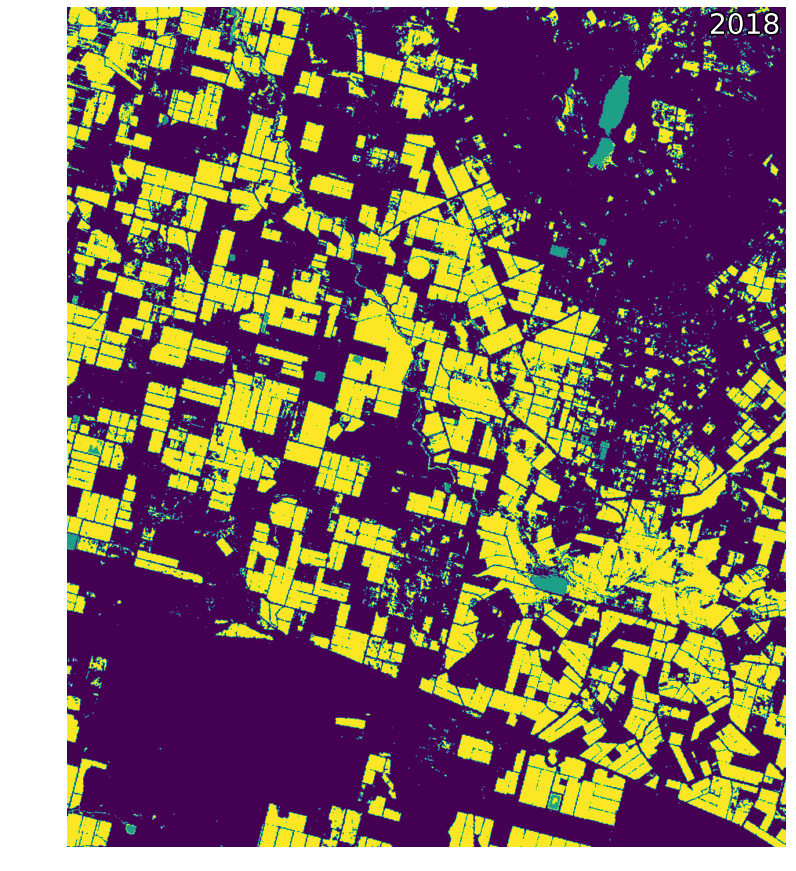

In [3]:
DEAPlotting.animated_timeseries(ds=y, output_path='results/griffith_cropped.gif',
                                interval=1000, bands=['lcc'], onebandplot_cbar=False, onebandplot_kwargs={'cmap':'viridis'}) 

#### RGB animation

In [ ]:
# Set up datacube instances
dc = datacube.Datacube(app='Time series animation')

# Study area name used for output file
study_area = 'Griffith'

# Set up analysis data query using a buffer around a lat-long point (1280 x 720)
lat1, lat2, lon1, lon2 = -34.2, -34.5, 145.8, 146.1

query = {'lon': (lon1, lon2),
         'lat': (lat1, lat2),    
         'time': ('2000-01-01', '2018-12-31'),
         'crs': 'EPSG:3577'}

# Custom mask that includes only cloudy or cloud shadowed pixels with data for all bands
custom_mask = {'cloud_acca': 'no_cloud', 
               'cloud_fmask': 'no_cloud', 
               'cloud_shadow_acca': 'no_cloud_shadow',
               'cloud_shadow_fmask': 'no_cloud_shadow',
               'contiguous': True}

# Load in data
ls578_ds = dc.load(product='ls8_nbart_geomedian_annual', **query, )

In [ ]:
dc = datacube.Datacube(app='Time series animation')

query_ls8 = {'lat': (-34.2, -34.5),
         'lon': (145.8, 146.1),
         'time':('2013-01-01', '2018-12-31')}

query_ls7 = {'lat': (-34.2, -34.5),
         'lon': (145.8, 146.1),
         'time':('2000-01-01', '2012-12-31')}

ls8 = dc.load(product='ls8_nbart_geomedian_annual', group_by='solar_day', **query_ls8)
ls7 = dc.load(product='ls7_nbart_geomedian_annual', group_by='solar_day', **query_ls7)
# ls5 = dc.load(product='ls5_nbart_geomedian_annual', group_by='solar_day', **query)

In [ ]:
gm = ls7.merge(ls8)

In [ ]:
DEAPlotting.animated_timeseries(ds=gm, output_path='results/griffith_truecolor.gif', 
                                bands=['red', 'green', 'blue'],
                                interval=1000) 

### Cuts/drafts

In [ ]:
# def ENVI_get_geotransform(filename):
#     '''
#     retruns the geotransform object from
#     and envi .hdr file
#     '''
#     driver = gdal.GetDriverByName('ENVI') 
#     driver.Register()

#     inDs = gdal.Open(filename, GA_ReadOnly)

#     print('get georeference information')
#     geotransform = inDs.GetGeoTransform()
#     originX = geotransform[0]
#     originY = geotransform[3]
#     pixelWidth = geotransform[1]
#     pixelHeight = geotransform[5]

#     return geotransform

# def readimgfile(filename, pnum, tgt, data, col):
#     """
#     Opens a .img envi file and returns a np array
#     """
#     #print(filename)
#     imgdata=np.fromfile(filename, dtype=np.float32)
#     #print(imgdata, imgdata.shape, tgt*pnum)
#     oneblock=imgdata[tgt*pnum:(tgt+1)*pnum]
#     #print(oneblock)
#     #print(oneblock.shape)
#     data[:, col]=imgdata[tgt*pnum:(tgt+1)*pnum]
    
# directory = "/g/data1a/r78/cb3058/dea-notebooks/crop-extents/data_dir/griffith/2000/"
# filename= directory + "phg_msavi.img"
# parafile=directory+'/ts_irow_icol.csv'
# tmm = pd.read_csv(parafile, header =None)
# nrow=tmm.values[1:3][0][0]
# ncol=tmm.values[1:3][1][0]
# print (nrow, ncol)
# pnum = nrow*ncol
# tgt=4
# col=0

# readimgfile(filename, pnum, tgt, data, col)
# geotransform =  ENVI_get_geotransform(file_name) 